In [68]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime as dt
import re 
import yfinance as yf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import requests
from get_all_tickers import get_tickers as gt
import bs4 as bs  # beautiful soups for web-scraping
import os
import pandas_datareader.data as pdr
import seaborn as sns

In [2]:
# user-defined functions
def clean_date_index(df):
    '''cleans date index of a dataframe such that the new format becomes year_period'''
    df.index = [str(x.year) + "_" + str(x.quarter) for x in df.index]
    return df

def calc_rets(df=None, nRows=None, nCols=None, index=None):
    '''calculates period returns given period price time series data within a dataframe'''
    rets = pd.DataFrame(np.zeros((nRows, nCols)), index = df.index, columns = index)
    for i in range(nCols):
        rets.iloc[:,i] = df.iloc[:,i] / df.iloc[:,i].shift(1) - 1
    rets = rets.shift(-1)  # shift n+1 period return into the n period row
    return rets

def qtr_hist_mkt_cap(ticker, start_qtr, end_qtr):
    '''outputs a dataframe with historical market cap data over quarterly periods from 2007-2020 given a ticker'''
    
    url_1 = "https://financialmodelingprep.com/api/v3/historical-market-capitalization/"
    url_2 = f"{ticker}?period=month&apikey=f0060c7a7b275396c21cb98f4985f3ae"
    mkt_cap = requests.get(url_1 + url_2)
    mkt_cap = mkt_cap.json()
    mkt_cap = pd.DataFrame(mkt_cap).set_index('date').drop(columns = ['symbol'], axis = 1)
    mkt_cap.index = pd.to_datetime(mkt_cap.index)
    mkt_cap = mkt_cap.resample('1M').mean()
    mkt_cap = mkt_cap.iloc[::3, :]  # quarterly data
    mkt_cap = clean_date_index(mkt_cap)
    mkt_cap = mkt_cap.loc[start_qtr:end_qtr,]  # slice data into sample timeframe
    mkt_cap.columns = pd.MultiIndex.from_tuples([(ticker, 'mkt_cap')])
    mkt_cap.index.names = ['qtr']
    return mkt_cap

def daily_hist_mkt_cap(ticker):
    '''outputs a dataframe with daily historical market cap data over entire history of the stock given a ticker'''
    
    url_1 = "https://financialmodelingprep.com/api/v3/historical-market-capitalization/"
    url_2 = f"{ticker}?apikey=f0060c7a7b275396c21cb98f4985f3ae"
    mkt_cap = requests.get(url_1 + url_2)
    mkt_cap = mkt_cap.json()
    mkt_cap = pd.DataFrame(mkt_cap).set_index('date').drop(columns = ['symbol'], axis = 1)
    mkt_cap.columns = pd.MultiIndex.from_tuples([(ticker, 'mkt_cap')])
    mkt_cap.index.names = ['qtr']
    return mkt_cap
    
def Piotroski_F_score(ticker, df):
    '''computes Piotroski F-score for a given ticker and dataframe of Bloomberg finanical data;
    outputs Series object of F-scores '''
    
    # factor components
    ROA = df[ticker]["RETURN_ON_ASSET"]  # return on assets
    CFO = df[ticker]["CF_CASH_FROM_OPER"]  # cashflow from operations
    dROA = ROA.diff(4)  # y/y change in ROA 
    dTURN = df[ticker]['ASSET_TURNOVER'].diff(4)  # y/y change in asset turnover ratio
    dLEVER = df[ticker]['TOT_DEBT_TO_TOT_ASSET'].diff(4)  # y/y change leveraged assets
    # accrual
    NET_INCOME = df[ticker]["NET_INCOME"]
    TOT_CURR_ASSET = df[ticker]["BS_CUR_ASSET_REPORT"]
    TOT_CURR_LIABILITIES = df[ticker]['BS_CUR_LIAB']
    ACCRUAL = (NET_INCOME - CFO)/TOT_CURR_ASSET.shift(4)
    # y/y change in liquidity
    dLIQUID = TOT_CURR_ASSET/TOT_CURR_LIABILITIES - TOT_CURR_ASSET.shift(4)/TOT_CURR_LIABILITIES.shift(4)  
    dMARGIN = df[ticker]['GROSS_MARGIN'].diff(4)  # y/y change in gross margin ratio

    # factors
    f_index = ROA.index
    F_ROA = pd.Series(np.where(ROA > 0, 1, 0))  # F_ROA
    F_ROA.index = f_index
    F_dROA = pd.Series(np.where(dROA > 0, 1, 0))  # F_dROA
    F_dROA.index = f_index
    F_CFO = pd.Series(np.where(ROA > 0, 1, 0))  # F_CFO
    F_CFO.index = f_index
    F_ACCRUAL = pd.Series(np.where(CFO > ROA, 1, 0))  # F_ACCRUAL
    F_ACCRUAL.index = f_index
    F_dLEVER = pd.Series(np.where(dLEVER < dLEVER.shift(1), 1, 0))  # F_dLEVER
    F_dLEVER.index = f_index
    F_dLIQUID = pd.Series(np.where(dLIQUID > 0, 1, 0))  # F_dLIQUID
    F_dLIQUID.index = f_index
    F_dMARGIN = pd.Series(np.where(dMARGIN > 0, 1, 0))  # F_dMARGIN
    F_dMARGIN.index = f_index
    F_dTURN = pd.Series(np.where(dTURN > 0, 1, 0))  # F_dTURN
    F_dTURN.index = f_index

    # F-score
    F_score = F_ROA + F_dROA + F_CFO + F_ACCRUAL + F_dLEVER + F_dLIQUID + F_dMARGIN + F_dTURN 
    F_score = F_score[4:]  # remove the first year
    
    # construct DataFrame
    f_score_data = pd.DataFrame(F_score, index = F_score.index, columns = [ticker])
    f_score_data.columns = pd.MultiIndex.from_tuples([(ticker, 'f_score')])
    f_score_data.index.names = ['qtr']
    
    return f_score_data

The below tickers are the current tickers in the S&P 500...
- Ideally I would like to include all tickers that have been in the S&P 500 over the past 5 years or so, including those that have delisted.
    - Dieyna was able to get a list of historical S&P500 ticker data. However it is proving difficult to do anything useful with the data because there are no easy (or cheap) ways of getting historical financial statement data given a list of tickers (ticker is not a great identifier for a stock).
- How to deal with stock ticker name changes?

In [3]:
# fundamental data of companies in S&P 500 sourced from Bloomberg Terminal
SP_500_fund_df = pd.read_excel('SP500_fundamental_data.xlsx', index_col = 0, header=[0,1])
SP_500_fund_df = SP_500_fund_df.rename(str.strip, axis='columns')  # strip trailing whitespace from column names
SP_500_fund_df = clean_date_index(SP_500_fund_df)
SP_500_fund_df.tail(16)

A                                                    \
Dates  RETURN_ON_ASSET CF_CASH_FROM_OPER BS_CUR_ASSET_REPORT BS_CUR_LIAB   
2017_1          6.7088               116                3635        1089   
2017_2          7.4348               257                3800        1187   
2017_3          7.9150               228                3996        1241   
2017_4          8.4340               288                4169        1263   
2018_1          2.3657               215                4397        1361   
2018_2          2.8214               303                4525        1365   
2018_3          3.5882               197                3667        1014   
2018_4          3.7249               372                3848        1171   
2019_1         12.9178               213                3712        1095   
2019_2         12.5463               252                3812        1118   
2019_3         12.6311               242                3457        1622   
2019_4         11.9046               314                3189        2080   
2020_1          8.2805               -59                3102        1892   
2020_2          7.3930               313                3171        1945   
2020_3          7.6055               290                3245        1314   
2020_4          7.5371               377                3415        1467   

                                                                     \
Dates  TOT_DEBT_TO_TOT_ASSET ASSET_TURNOVER NET_INCOME GROSS_MARGIN   
2017_1               25.3049         0.5590        168      53.7957   
2017_2               25.4865         0.5524        164      53.7205   
2017_3               25.1907         0.5494        175      53.5009   
2017_4               23.8666         0.5514        177      54.4155   
2018_1               24.6608         0.5572       -320      55.3262   
2018_2               24.0779         0.5619        205      53.3997   
2018_3               21.5475         0.5790        236      54.7797   
2018_4               21.0631         0.5792        195      54.7141   
2019_1               20.0849         0.5651        504      55.0623   
2019_2               19.9291         0.5637        182      54.0388   
2019_3               20.8464         0.5997        191      54.3171   
2019_4               25.4655         0.5739        194      53.9137   
2020_1               27.9339         0.5675        197      53.2793   
2020_2               28.3131         0.5668        101      53.0695   
2020_3               26.2728         0.5749        199      53.0531   
2020_4               26.3530         0.5597        222      53.1355   

                   AAL                    ...       ZION               \
Dates  RETURN_ON_ASSET CF_CASH_FROM_OPER  ... NET_INCOME GROSS_MARGIN   
2017_1          4.5174              2250  ...      139.0          NaN   
2017_2          4.2726              1688  ...      168.0          NaN   
2017_3          4.1620               369  ...      160.0          NaN   
2017_4          2.4640               636  ...      123.0          NaN   
2018_1          2.0792              1800  ...      238.0          NaN   
2018_2          1.4968              1094  ...      197.0          NaN   
2018_3          0.9597               -77  ...      223.0          NaN   
2018_4          2.4805               986  ...      226.0          NaN   
2019_1          2.5108              1651  ...      213.0          NaN   
2019_2          2.6844               736  ...      198.0          NaN   
2019_3          2.7959               828  ...      222.0          NaN   
2019_4          2.7966               124  ...      183.0          NaN   
2020_1         -1.2399              -168  ...       14.0          NaN   
2020_2         -5.4841              -908  ...       66.0          NaN   
2020_3        -10.1543             -2604  ...      175.0          NaN   
2020_4        -14.5652             -2863  ...      284.0          NaN   

                   ZTS                                    

In [4]:
# ticker list
tickers = list(set(SP_500_fund_df.columns.get_level_values(0)))
tickers.sort()

# compute Piotroski F-scores given S&P 500 ticker and construct dataframe with all tickers (0 = lowest, 8 = highest)
f_score_df = Piotroski_F_score(tickers[0], SP_500_fund_df)

for ticker in tickers[1:]:
    f_score = Piotroski_F_score(ticker, SP_500_fund_df)
    f_score_df = pd.merge(f_score_df, f_score, on='qtr', how='left')

# historical market cap data using FMP API 
start_qtr = '2007_1'
end_qtr = '2020_4'

mkt_cap_df = qtr_hist_mkt_cap(tickers[0], start_qtr, end_qtr)

for ticker in tickers[1:]:
    print(ticker)
    mkt_cap = qtr_hist_mkt_cap(ticker, start_qtr, end_qtr)
    mkt_cap_df = pd.merge(mkt_cap_df, mkt_cap, on='qtr', how='left')
    
mkt_cap_df = mkt_cap_df/1000000  # scale down by 1 million

AAL
AAP
AAPL
ABBV
ABC
ABMD
ABT
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALK
ALL
ALLE
AMAT
AMCR
AMD
AME
AMGN
AMP
AMT
AMZN
ANET
ANSS
ANTM
AON
AOS
APA
APD
APH
APTV
ARE
ATO
ATVI
AVB
AVGO
AVY
AWK
AXP
AZO
BA
BAC
BAX
BBWI
BBY
BDX
BEN
BF-B
BIIB
BIO
BK
BKNG
BKR
BLK
BLL
BMY
BR
BRK-B
BRO
BSX
BWA
BXP
C
CAG
CAH
CARR
CAT
CB
CBOE
CBRE
CCI
CCL
CDAY
CDNS
CDW
CE
CERN
CF
CFG
CHD
CHRW
CHTR
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COST
CPB
CPRT
CRL
CRM
CSCO
CSX
CTAS
CTLT
CTRA
CTSH
CTVA
CTXS
CVS
CVX
CZR
D
DAL
DD
DE
DFS
DG
DGX
DHI
DHR
DIS
DISCA
DISCK
DISH
DLR
DLTR
DOV
DOW
DPZ
DRE
DRI
DTE
DUK
DVA
DVN
DXC
DXCM
EA
EBAY
ECL
ED
EFX
EIX
EL
EMN
EMR
ENPH
EOG
EQIX
EQR
ES
ESS
ETN
ETR
ETSY
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FANG
FAST
FB
FBHS
FCX
FDX
FE
FFIV
FIS
FISV
FITB
FLT
FMC
FOX
FOXA
FRC
FRT
FTNT
FTV
GD
GE
GILD
GIS
GL
GLW
GM
GNRC
GOOG
GOOGL
GPC
GPN
GPS
GRMN
GS
GWW
HAL
HAS
HBAN
HBI
HCA
HD
HES
HIG
HII
HLT
HOLX
HON
HPE
HPQ
HRL
HSIC
HST
HSY
HUM
HWM
IBM
ICE
IDXX
IEX
IFF
ILMN
INCY


In [5]:
# S&P quarterly returns over sample period
SPX_mo_prices = pd.read_excel('SP500_mo_price_data_07-20.xlsx', index_col=0)
SPX_qtr_prices = SPX_mo_prices.iloc[::3]
SPX_qtr_prices = clean_date_index(SPX_qtr_prices)  # clean date index
N = SPX_qtr_prices.shape[0]
M = SPX_qtr_prices.shape[1]
SPX_qtr_rets = calc_rets(SPX_qtr_prices, N, M, ["SPX_qtr_rets"])

In [19]:
# price per earnings ratio 
SP500_PE_ratio = pd.read_excel('SP500_PE_ratio_monthly_07-20.xlsx', index_col=0, header = [0,1])
SP500_PE_ratio = SP500_PE_ratio.rename(str.strip, axis='columns')  # strip trailing whitespace from column names
SP500_PE_ratio = SP500_PE_ratio.iloc[::3, :]  # quarterly data
SP500_PE_ratio = clean_date_index(SP500_PE_ratio)  # clean date index

# create multi-level quarterly returns df
N = SP500_PE_ratio.shape[0]
tickers = list(SP500_PE_ratio.columns.get_level_values(0))  # level 1
tickers = list(set(tickers))  # keep only unique ticker names
ret_col = ["qtr_ret"]*len(tickers)  # level 2
tuples = list(zip(tickers, ret_col))
index = pd.MultiIndex.from_tuples(tuples, names=[None, "Dates"])

qtr_rets = calc_rets(SP500_PE_ratio, N, len(tickers), index)

# merge PE ratio dataset to future qtr return dataset
PE_ratio_qtr_rets_df = pd.merge(SP500_PE_ratio, qtr_rets, left_index=True, right_index=True)
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.sort_index(axis=1)
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.drop('PX_LAST', axis=1, level=1)  # drop "Last Price" col

# create stacked dataframe and clean
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.stack(0)
PE_ratio_qtr_rets_df
PE_ratio_qtr_rets_df['EP_RATIO'] = np.reciprocal(PE_ratio_qtr_rets_df['PE_RATIO'])  # create Earnings/Price Ratio col
PE_ratio_qtr_rets_df.drop(PE_ratio_qtr_rets_df.columns[0], axis=1, inplace=True)  # drop PE_RATIO col
PE_ratio_qtr_rets_df['EP_RATIO'].fillna(0, inplace=True)  # change NaN values to 0 in EP_RATIO col
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df[["EP_RATIO", "qtr_ret"]]
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.dropna()

# merge SPX market returns
PE_ratio_qtr_rets_df.index.names = ['qtr', 'ticker']
SPX_qtr_rets.index.names = ['qtr']
df = pd.merge(PE_ratio_qtr_rets_df.reset_index(), 
              SPX_qtr_rets.reset_index(),
              how='inner',
              on='qtr').set_index(['qtr', 'ticker'])

# merge mkt cap data to panel df
mkt_cap_stacked = mkt_cap_df.stack(0)
mkt_cap_stacked.index.names = ['qtr','ticker']
df = pd.merge(df.reset_index(), 
              mkt_cap_stacked.reset_index(),
              how='inner',
              on=['qtr','ticker']).set_index(['qtr', 'ticker'])

# merge F-score data to panel df 
f_score_stacked = f_score_df.stack(0)
f_score_stacked.index.names = ['qtr','ticker']
df = pd.merge(df.reset_index(), 
              f_score_stacked.reset_index(),
              how='inner',
              on=['qtr','ticker']).set_index(['qtr', 'ticker'])

# create column for the median market cap of all assets in each quarter
median_mkt_cap = df.groupby(by='qtr').median()[['mkt_cap']]
median_mkt_cap.columns = ['median_mkt_cap']
df = df.join(median_mkt_cap, how='left')

# create dummy market cap column (1 = mkt_cap >= median mkt_cap; 0 = mkt_cap < median mkt_cap)
df['size'] = 0
df.loc[df['mkt_cap'] >= df['median_mkt_cap'], 'size'] = 1

# create interaction terms between company size and EP Ratio and F-Score, respectively
df['EP_ratio_size'] = df['EP_RATIO'] * df['size']
df['f_score_size'] = df['f_score'] * df['size']

# create beats_market column (underperforms = 0; outperforms/equals = 1)
df['beats_market'] = 0
df.loc[df['qtr_ret'] >= df['SPX_qtr_rets'], 'beats_market'] = 1
df.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/regression_data.csv")
df

EP_RATIO   qtr_ret  SPX_qtr_rets       mkt_cap  f_score  \
qtr    ticker                                                            
2007_1 A       0.057223  0.003919      0.030683   9769.315789        5   
       AAP     0.000000  0.006276      0.030683   4041.407263        2   
       ABC     0.048007  0.123034      0.030683   9497.865000        5   
       ABMD    0.000000  0.025375      0.030683    383.278500        4   
       ABT     0.086179  0.008092      0.030683  37920.682400        3   
...                 ...       ...           ...           ...      ...   
2020_3 YUM     0.031896 -0.020058     -0.000355  28517.814543        3   
       ZBH     0.045735 -0.141978     -0.000355  26487.226009        2   
       ZBRA    0.036412 -0.139863     -0.000355  15147.520991        3   
       ZION    0.083694 -0.113247     -0.000355   5366.906746        3   
       ZTS     0.024033 -0.171231     -0.000355  75728.079764        4   

               median_mkt_cap  size  EP_ratio_size  f_score_size  beats_market  
qtr    ticker                                                                   
2007_1 A         10405.558591     0       0.000000             0             0  
       AAP       10405.558591     0       0.000000             0             0  
       ABC       10405.558591     0       0.000000             0             1  
       ABMD      10405.558591     0       0.000000             0             0  
       ABT       10405.558591     1       0.086179             3             0  
...                       ...   ...            ...           ...           ...  
2020_3 YUM       23593.567450     1       0.031896             3             0  
       ZBH       23593.567450     1       0.045735             2             0  
       ZBRA      23593.567450     0       0.000000             0             0  
       ZION      23593.567450     0       0.000000             0             0  
       ZTS       23593.567450     1       0.024033             4             0  

[22516 rows x 10 columns]

<AxesSubplot:>

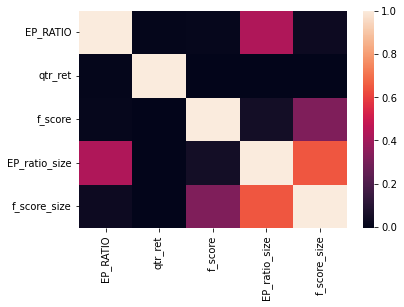

In [23]:
df_temp = df.reset_index()
df_temp = df_temp.drop(['mkt_cap', 'beats_market','median_mkt_cap','size','SPX_qtr_rets'], axis=1)
corr_matrix = df_temp.corr()
sns.heatmap(corr_matrix)

In [93]:
# logistic regression model
x_cols = ['EP_RATIO', 'EP_ratio_size', 'f_score_size', 'f_score']
y_col = 'beats_market'

X = pd.DataFrame(df[x_cols])
Y = df[y_col]
X_train = X.loc['2007_1':'2015_2',:]
Y_train = Y.loc['2007_1':'2015_2',:]
X_test = X.loc['2015_3':'2016_4',:]
Y_test = Y.loc['2015_3':'2016_4',:]
print('training data shape: ', X_train.shape)
print('test data shape: ', X_test.shape)
print('proportion = ', X_test.shape[0] / X_train.shape[0])  # about an 80 - 20 split between training and test data

training data shape:  (12748, 4)
test data shape:  (2685, 4)
proportion =  0.21062127392532162


In [98]:
# train model
scaler = MinMaxScaler()

# scale training data
scaled_EP_ratio_train = scaler.fit_transform(X_train[['EP_RATIO']])
scaled_f_score_train = scaler.fit_transform(X_train[['f_score']])
scaled_EP_ratio_size_train = scaler.fit_transform(X_train[['EP_ratio_size']])
scaled_f_score_size_train = scaler.fit_transform(X_train[['f_score_size']])
X_train.loc[:,['EP_RATIO']] = scaled_EP_ratio_train 
X_train.loc[:, ['f_score']] = scaled_f_score_train
X_train.loc[:, ['EP_ratio_size']] = scaled_EP_ratio_size_train
X_train.loc[:, ['f_score_size']] = scaled_f_score_size_train

# scale test data
scaled_EP_ratio_test = scaler.fit_transform(X_test[['EP_RATIO']])
scaled_f_score_test = scaler.fit_transform(X_test[['f_score']])
scaled_EP_ratio_size_test = scaler.fit_transform(X_test[['EP_ratio_size']])
scaled_f_score_size_test = scaler.fit_transform(X_test[['f_score_size']])
X_test.loc[:,['EP_RATIO']] = scaled_EP_ratio_test
X_test.loc[:, ['f_score']] = scaled_f_score_test
X_test.loc[:, ['EP_ratio_size']] = scaled_EP_ratio_size_test
X_test.loc[:, ['f_score_size']] = scaled_f_score_size_test

X_train['intercept'] = 1
X_test['intercept'] = 1

lrg = sm.Logit(Y_train, X_train).fit()  # statsmodels logit 

lreg = LogisticRegression(penalty='none').fit(X_train, Y_train)  # scikit-learn log regression -- no regularization

# above two packages should result in the same coefficients
print(lreg.coef_)
lrg.summary()

Optimization terminated successfully.
         Current function value: 0.692993
         Iterations 4
[[ 0.02991714  0.59052254 -0.04128166 -0.12722567  0.03197743]]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           beats_market   No. Observations:                12748
Model:                          Logit   Df Residuals:                    12743
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:               0.0002138
Time:                        01:21:01   Log-Likelihood:                -8834.3
converged:                       True   LL-Null:                       -8836.2
Covariance Type:            nonrobust   LLR p-value:                    0.4367
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
EP_RATIO          0.0298      0.443      0.067      0.946      -0.838       0.898
EP_ratio_size     0.5890      0.665      0.886      0.376      -0.715       1.893
f_score_size     -0.0410      0.082     -0.503      0.615      -0.201       0.119
f_score          -0.1275      0.096     -1.330      0.183      -0.315       0.060
intercept         0.0641      0.059      1.083      0.279      -0.052       0.180
=================================================================================
"""

In [99]:
# 5-fold cv
k = 5
scores = cross_val_score(lreg, X, Y, cv=k)  # accuracy using 5-fold cv
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.52131439 0.51099267 0.50344215 0.5227626  0.51387964]
0.51 accuracy with a standard deviation of 0.01


In [100]:
# prediction
y_pred = lrg.predict(X_test)
prediction = list(map(round, y_pred))

Text(0.5, 1.0, 'Accuracy Score: 0.49906890130353815')

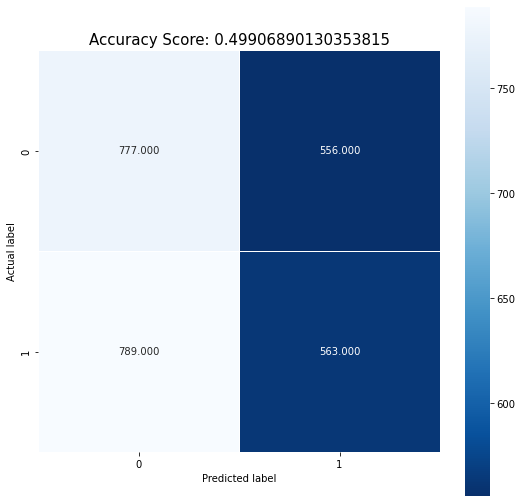

In [101]:
# accuracy
score = lreg.score(X_test, Y_test)
cm = confusion_matrix(Y_test, prediction)

# plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [ ]:
# at what rate do we beat the market in our observed set?
print(np.mean(df.beats_market))

In [125]:
# df_2010_1 = df.xs('2010_1')
# df_2010_1['qtr_ret']
df_groupby_ticker = df.groupby('ticker').mean()
df_groupby_ticker.describe()

,EP_RATIO,qtr_ret,SPX_qtr_rets,mkt_cap,f_score,median_mkt_cap,size,EP_ratio_size,f_score_size,beats_market
count,494.000000,494.000000,494.000000,4.940000e+02,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,0.053117,0.056290,0.019972,3.831919e+04,4.859904,16513.328250,0.489469,0.026619,2.423025,0.486018
std,0.035147,0.250645,0.005239,7.611382e+04,0.861563,2557.168786,0.427745,0.030074,2.185829,0.107581
min,0.000000,-0.459283,-0.000355,6.823686e+02,0.000000,14764.293581,0.000000,0.000000,0.000000,0.000000
25%,0.033486,0.008612,0.017460,9.001319e+03,4.545455,14981.771425,0.000000,0.000000,0.000000,0.418182
50%,0.052167,0.026221,0.017460,1.724659e+04,5.036364,14981.771425,0.490909,0.012341,2.372727,0.490909
75%,0.069613,0.046234,0.022739,3.479132e+04,5.380114,17546.543353,1.000000,0.051095,4.763636,0.545455
max,0.533532,4.942422,0.061561,1.118365e+06,6.666667,23593.567450,1.000000,0.143913,6.300000,1.000000


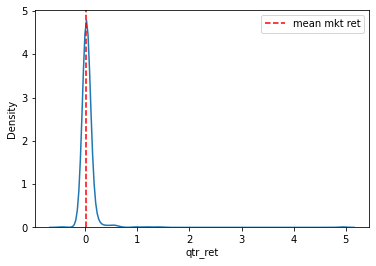

In [141]:
# distribution of quarterly asset returns to market return aggregated over entire in-sample period
sns.kdeplot(data=df_groupby_ticker, x='qtr_ret')
plt.axvline(df_groupby_ticker['SPX_qtr_rets'].mean(), color='red', linestyle='--', label='mean mkt ret') 
plt.legend()

We see above that the distribution of the average asset returns is symmetric about the average market return, as expected. 

## Areas for Further Research (if given more time):  
* I would like to test this model on older data. Joseph Piotroski tested his F-score methodology on stock data from 1976 to 1996 and created a long-short investment strategy based on his fundamental metric to achieve a 23% annual return within the time period. As an important note, Piotroski focused his methodology on companies with high book-to-market ratios, in other words companies that are undervalued by the market. However, this period of time was before the true emergence of the internet and the high-growth tech companies (Amazon, Netflix, Facebook, to name a few) that grew with it, most of which currently hold lofty valuations. With exponential improvements in techology, one may hypothesize that active investors in this millenium place a larger emphasis on projected growth and future earnings compared to pre-internet times. Clearly, we observe today that tech companies are often priced many times higher than its earnings (Tesla is a good example), whereas this was likely not the case during the 1970s (would like to verify this). If this is indeed the case, then it would make sense that the fundamental metrics Piotroski used are not as effective in predicting future outperformance.  <br>


* I would like to do more data visualization before constructing the regression model. The parameters I choose are based off of my own theories on how to select stocks likely to outperform the market. However, we find that these predictors are not very significant. I would like to start with analyzing the relationship between outperformance and many different types of factors (technical and fundamental) to get an improved sense of what the potentially signficant relationships are before constructing the model.